Group members:
- Hongyuan Fan (500107588)
- Quynh Giang Le (530190754)
- Sitian Huang (530387686)
- Shanhui Liu (530836391)
- Fabiola Bella Wibowo (530435367)

# Process

## Data Model Design

The central entity, ‘PatientVisits’, connects to ‘Patients’, ‘Doctors’, ‘Hospitals’, ‘Medications’, and ‘Biometrics’.  There are multiple relationships linked between each other: a patient can have 1 or multiple visits, a doctor can attend 0 to multiple visits, hospitals host 0 to multiple visits, and visits may contain 1 medication and biometric test when there is a new record added inside.


![ERD](COMP5339_ERD.png)

## Data Cleaning and Preprocessing

This includes correcting data types, removing duplicate rows, handling missing values and outliers. 
- Outliers are detected using the IQR method. True outliers such as 1000, 1900, etc are unrealistic. For the others, they are abnormal but realistic if the patients have disease. We defined the range as follows:
    + Heart rate: Regarding American Heart Association (2024) and Mayo Clinic (2024), normal is 40-140, so we use 30-200 as acceptable range.
    + Blood pressure: Regarding LeWine (2023) and Laskowski (2022), the normal range is from 60-180. Therefore, considering unhealthy patients, the accepted range is 30-250.
-  Missing numerical values are filled with the mean because the percentage of missing values is small so we can't detect any pattern in missing values. Categorical columns are filled with mode or "Unknown". The target column "Diagnosis" is filled with "Stroke" or "No Stroke," encoded as 1 and 0, respectively, to focus on identifying stroke cases.
- Normalization is performed using Min-Max Scaling for selected numeric columns to scale them into [0,1] range for future modeling.

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f 
from pyspark.ml.feature import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn

In [15]:
# Initialize Spark Session:
spark = SparkSession.builder.appName("StrokeDiagnosis").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

In [3]:
def data_cleaning_and_preprocessing(patients, doctors, hospitals, medications, patient_visits, biometrics):
    # Correct data types
    spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
    patients = patients.withColumn("BirthDate", f.to_date(f.col("BirthDate"), "dd/MM/yyyy"))
    patient_visits = patient_visits.withColumn("VisitDate", f.to_date(f.col("VisitDate"), "yyyy-MM-dd"))
    patients = patients.withColumn("Annual Income", f.col("Annual Income").cast("double"))
    biometrics = biometrics.withColumn("Height", f.col("Height").cast("double"))
    biometrics = biometrics.withColumn("Weight", f.col("Weight").cast("double"))
    biometrics = biometrics.withColumn("BloodPressure", f.col("BloodPressure").cast("double"))
    biometrics = biometrics.withColumn("HeartRate", f.col("HeartRate").cast("double"))
    
    # Duplicate rows handling
    patients = patients.dropDuplicates()
    doctors = doctors.dropDuplicates()
    hospitals = hospitals.dropDuplicates()
    medications = medications.dropDuplicates()
    patient_visits = patient_visits.dropDuplicates()
    biometrics = biometrics.dropDuplicates()
    
    # Deal with outliers for BloodPressure and HeartRate by replacing with mean for numerical value.
    mean_blood_pressure = biometrics.agg(f.mean(f.when((f.col("BloodPressure") <= 250) & (f.col("BloodPressure") >= 30), f.col("BloodPressure")).otherwise(0))).collect()[0][0]
    biometrics = biometrics.withColumn("BloodPressure", f.when((f.col("BloodPressure") > 250) | (f.col("BloodPressure") < 30), f.lit(mean_blood_pressure)).otherwise(f.col("BloodPressure")))
    mean_heart_rate = biometrics.agg(f.mean(f.when((f.col("HeartRate") <= 200) & (f.col("HeartRate") >= 30), f.col("HeartRate")).otherwise(0))).collect()[0][0]
    biometrics = biometrics.withColumn("HeartRate", f.when((f.col("HeartRate") > 200) | (f.col("HeartRate") < 30), f.lit(mean_heart_rate)).otherwise(f.col("HeartRate")))
    
    # Missing Values Handling

    # Fill missing values in categorical columns with the mode (Most Frequent value)
    mode_gender = patients.groupBy("Gender").agg(f.count("Gender").alias("count")).orderBy(f.col("count").desc()).first()[0]
    patients = patients.fillna({'FirstName': 'Unknown', 'LastName': 'Unknown', 'Gender': mode_gender})

    # Fill missing values in numerical columns with the mean
    for col_name in ['Annual Income']:
        mean_value = patients.agg(f.mean(f.col(col_name)).alias(col_name)).collect()[0][col_name]
        patients = patients.withColumn(col_name, f.when(f.col(col_name).isNull(), f.lit(mean_value)).otherwise(f.col(col_name)))

    for col_name in ['BloodPressure', 'HeartRate', 'Height']:
        mean_value = biometrics.agg(f.mean(f.col(col_name)).alias(col_name)).collect()[0][col_name]
        biometrics = biometrics.withColumn(col_name, f.when(f.col(col_name).isNull(), f.lit(mean_value)).otherwise(f.col(col_name)))
    
    # Repace the NAN value as 0 and the "Stroke" factors with 1 in 'Diagnosis' attribute
    patient_visits = patient_visits.withColumn('Diagnosis', f.when(f.col('Diagnosis').isNull(), f.lit(0)).otherwise(f.col('Diagnosis')))
    patient_visits = patient_visits.withColumn('Diagnosis', f.when(f.col('Diagnosis') == 'Stroke', f.lit(1)).otherwise(f.col('Diagnosis')))
    
    # Normalize numerical attributes using Min-Max Scaling
    def normalize_column(df, input_col):
        max_val = df.agg({input_col: "max"}).collect()[0][0]
        min_val = df.agg({input_col: "min"}).collect()[0][0]
        df = df.withColumn(input_col+"_Normalized", (f.col(input_col) - min_val) / (max_val - min_val))
        return df

    biometrics = normalize_column(biometrics, 'Height')
    biometrics = normalize_column(biometrics, 'Weight')
    biometrics = normalize_column(biometrics, 'BloodPressure')
    biometrics = normalize_column(biometrics, 'HeartRate')
    patients = normalize_column(patients, 'Annual Income')
    
    return patients, doctors, hospitals, medications, patient_visits, biometrics

## ETL Pipeline

### Extract Stage

In this stage, six CSV are imported into the working environment. 

In [4]:
# Function to extract the data from sources
def extract_data():
    # Extract data from CSV files using spark.read.csv('./data/xxx.csv', header=True, inferSchema=True). Header=True enables the first line of the CSV file to contain column headers.inferSchema=True enables Spark to automatically infer the data types of each column based on the data in the CSV file. If inferSchema=False, all columns are read as strings by default.
    patients = spark.read.csv('Patients.csv', header=True, inferSchema=True)
    doctors = spark.read.csv('Doctors.csv', header=True, inferSchema=True)
    hospitals = spark.read.csv('Hospitals.csv', header=True, inferSchema=True)
    medications = spark.read.csv('Medications.csv', header=True, inferSchema=True)
    patient_visits = spark.read.csv('PatientVisits.csv', header=True, inferSchema=True)
    biometrics = spark.read.csv('Biometrics.csv', header=True, inferSchema=True)
    return patients, doctors, hospitals, medications, patient_visits, biometrics

### Transform Stage

Not only data cleaning, this stage also involves renaming some columns and dropping others to prevent duplicate column names during join operations. Finally, all the cleaned datasets are merged into a single dataset. The missing values for medication are when the patient is diagnosed with "No Stroke". Therefore, we decided to fill the MedicationID with "-1" (because every ID column in the data sets starts with 1) and "NotGiven" for the other medication information.


In [5]:
# Function to transform data extracted from sources
def transform_data(patients, doctors, hospitals, medications, patient_visits, biometrics):
    # Cleaning the data first
    patients, doctors, hospitals, medications, patient_visits, biometrics = data_cleaning_and_preprocessing(patients, doctors, hospitals, medications, patient_visits, biometrics)
    
    # Drop this column due to model design
    biometrics = biometrics.drop("PatientID")
    
    # Rename the "FirstName", "DoctorFirstName" "HospitalID" "HospitalID" columns in doctors and hospitals datasets to avoid any conflicts
    doctors = doctors.withColumnRenamed("FirstName", "DoctorFirstName").withColumnRenamed("LastName", "DoctorLastName")
    hospitals = hospitals.withColumnRenamed("HospitalID", "HospitalID_Hospital")
    patient_visits = patient_visits.withColumnRenamed("HospitalID", "HospitalID_Visit")

    # Merging data sets
    combined_data = patient_visits.join(patients, on="PatientID", how="inner").join(doctors, on="DoctorID", how="inner").join(hospitals, patient_visits["HospitalID_Visit"] == hospitals["HospitalID_Hospital"], how="inner").join(biometrics, on=["BiometricsID"], how="inner").join(medications, on=["MedicationID"], how="left_outer")
    
    # Fill in the encoded data after merging to the missing values
    combined_data = combined_data.fillna({'MedicationID': -1, 'MedicationName': 'NotGiven', 'Dosage': 'NotGiven', 'SideEffects': 'NotGiven'})
    return combined_data

### Load Stage

In this stage, the final merged dataset is written to a csv file. 

In [6]:
def load_data(combined_data):
    # Save the combined dataset
    # The combined_data.coalesce(1) ensures that the output is consolidated into one file  to avoid writing data to multiple files by default. And it enables overwriting which means that if there is already data at the specified location (CombinedData.csv), it will be overwritten.
    combined_data.coalesce(1).write.csv('CombinedData.csv', header=True, mode='overwrite')

def etl():
    patients, doctors, hospitals, medications, patient_visits, biometrics = extract_data()
    combined_data = transform_data(patients, doctors, hospitals, medications, patient_visits, biometrics)
    load_data(combined_data)

In [7]:
# ETL Pipeline
etl()

## EDA

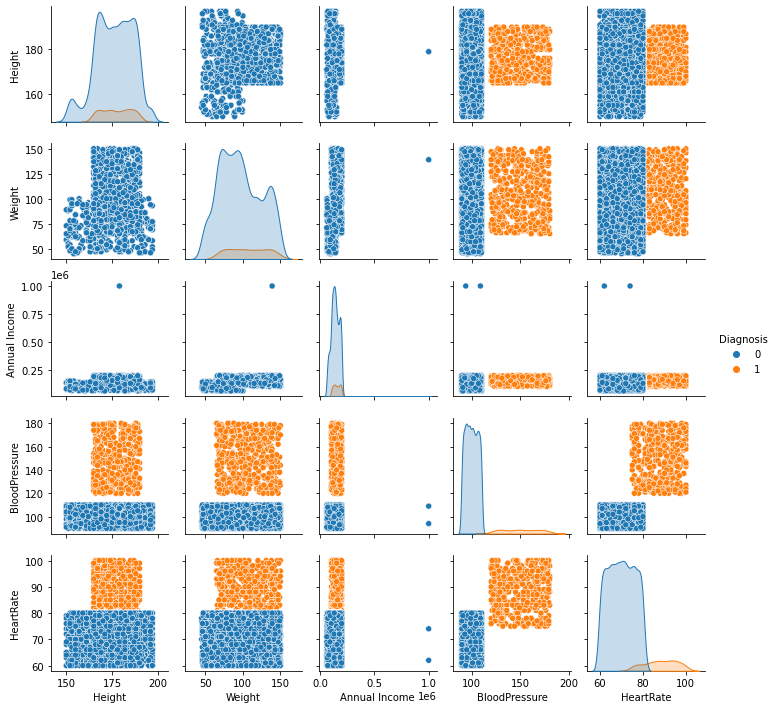

In [14]:
combined_data = spark.read.csv('CombinedData.csv', header=True, inferSchema=True)
pairplot_data = combined_data.select("Height", "Weight", "Annual Income", "BloodPressure", "HeartRate", "Diagnosis").toPandas()
seaborn.pairplot(pairplot_data, hue='Diagnosis', height=2, aspect=1)
plt.show()

This pairplot visualizes the relationships between various variables. The distribution reveals that most of the variables are relatively normally distributed, while Annual Income shows a highly skewed distribution with significant outliers. The scatterplots indicate no strong linear relationships between most pairs of variables, except for a modest correlation between Weight and Blood Pressure. Additionally, the Diagnosis variable indicates that higher Blood Pressure and Heart Rate values are more common in stroke cases.  


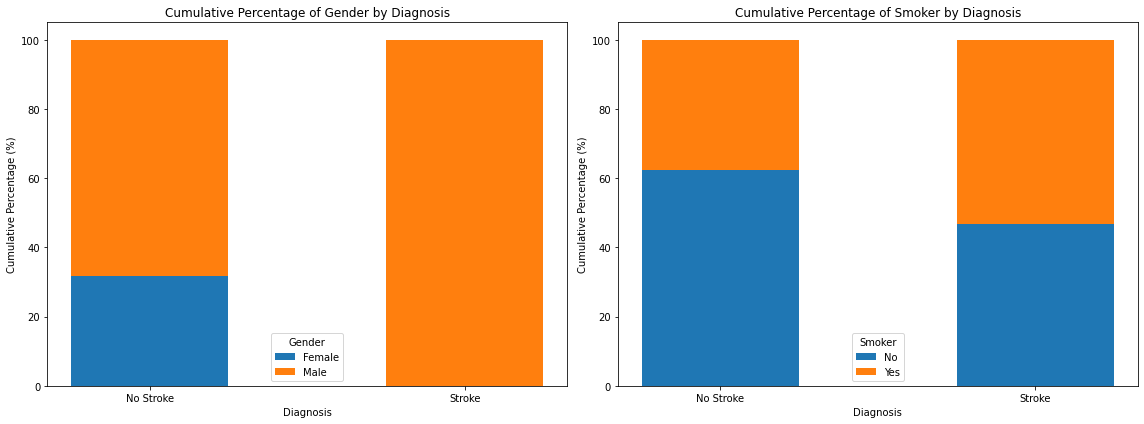

In [9]:
categorical_data = combined_data.select("Gender", "Smoker", "Diagnosis")

def plot_categorical_percentage(df, category, ax, title):
    # Calculate counts and percentages
    counts = df.groupby(['Diagnosis', category]).count()
    total_counts = df.groupby(['Diagnosis']).count().withColumnRenamed('count', 'TotalCount')
    percentages = counts.join(total_counts, on="Diagnosis", how="inner") \
                        .withColumn("Percentage", (f.col("count") * 100) / f.col("TotalCount"))

    # Pivot and convert to Pandas
    pivoted = percentages.groupBy('Diagnosis').pivot(category).sum('Percentage').fillna(0).toPandas()
    pivoted['Diagnosis'] = pivoted['Diagnosis'].astype('category')

    # Plot
    for col in pivoted.columns[1:]:
        ax.bar(pivoted['Diagnosis'], pivoted[col], label=col,
               bottom=pivoted.loc[:, pivoted.columns[1:]].cumsum(axis=1)[col] - pivoted[col], width=0.5)
    ax.set_xlabel('Diagnosis')
    ax.set_ylabel('Cumulative Percentage (%)')
    ax.set_title(title)
    ax.legend(title=category)
    ax.set_xticks(pivoted['Diagnosis'])
    ax.set_xticklabels(['Stroke', 'No Stroke'])

# Set up the figure for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for Gender
plot_categorical_percentage(categorical_data, 'Gender', axes[0], 'Cumulative Percentage of Gender by Diagnosis')

# Plot for Smoker
plot_categorical_percentage(categorical_data, 'Smoker', axes[1], 'Cumulative Percentage of Smoker by Diagnosis')

plt.tight_layout()
plt.show()

The 2 bar plots provide some insights into the relationship between diagnosis and two categorical variables: Gender and Smoking Status. The first plot suggests that males may be more likely to be diagnosed with a stroke, and no females in this specific dataset have been diagnosed with a stroke. The second plot suggests that a person who smokes is more likely to be diagnosed with a stroke compared to non-smokers.


# Challenges

**Challenge 1:** There are a few ambiguities when we try to describe the relationships between each entity during data modeling. For example, when we look at the variables in Doctors.csv, we thought each doctor would only be assigned to 1 hospital. However, if we look closer into PatientVisits.csv we found that the same doctor can be in multiple hospitals.

**Solution:** crosscheck with the data inside each csv before deciding the relationships. In case of confusion, we checked the related csv files to ensure the correctness of their relationships.

**Challenge 2:** The missing values are a small percentage of the data, making it difficult to assess any correlation with other variables so deleting them isn’t ideal since each record is linked to important information in another table. Outliers were detected statistically, but only a few are truly incorrect, while others, though extreme, are realistic. This makes it challenging to accurately filter out the incorrect values.

**Solution:** With the goal of automation and a small percentage of missing values, we'll impute them using the mean and mode. For outliers, instead of removing all identified ones, we'll use domain knowledge to establish an accepted range and eliminate only the unrealistic values 

# Summary

## Potential implication of findings

1. Data preprocessing and transforming could provide a decent foundation for creating and developing predictive models for stroke identification, with correctly handling data processing steps that could improve the model accuracy and generalizability. The insights from the data analysis process help to develop the targeted intervention strategy for stroke prevention for different user groups, while identifying the high-risk age groups and height/blood pressure/heart rate groups could also help to manage the healthcare resource.


2. The pipeline we designed is capable of handling large datasets and merging different sources while ensuring scalability and reusability between different healthcare areas, which could support a wider range and integrations for many kinds of existing healthcare systems.


## Future research potential

While this is a classification data set that uses the different factors that influence the diagnosis of a stroke, using this feature we could explore the future importance of each variable and further identify which factor will most likely lead to a stroke.

# References

American Heart Association. (2024, May 17). *Understanding Blood Pressure Readings.* Retrieved Sep 02, 2024, from https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings

Laskowski, E.R. (2022, Oct 08). *What's a normal resting heart rate?.* Mayo Clinic. https://www.mayoclinic.org/healthy-lifestyle/fitness/expert-answers/heart-rate/faq-20057979

LeWine, H.E. (2023, June 13). *What is a normal heart rate?.* Harvard Health Publishing. https://www.health.harvard.edu/heart-health/what-your-heart-rate-is-telling-you

Mayo Clinic. (2024, June 13). *Low blood pressure (hypotension).* Retrieved Sep 02, 2024, from https://www.mayoclinic.org/diseases-conditions/low-blood-pressure/symptoms-causes/syc-20355465


# Contributions

- **Hongyuan Fan (500107588):** Coding for cleaning, ETL, Report writing (Summary)
- **Quynh Giang Le (530190754):** Coding for ETL, EDA, Report writing (2 Challenges)
- **Sitian Huang (530387686):** Data Model Design, Report writing (ERD, EDA)
- **Shanhui Liu (530836391):** Data Model Design, Report writing (Data Cleaning, ETL)
- **Fabiola Bella Wibowo (530435367):** Data Model Design, Report writing (2 Challenges)